# Estimate uncertainty in models

In [1]:
from EvaluateModel import *
from collections import namedtuple
from DataLoader import ship_dataset, init_dataloader

data_params = namedtuple(
    'data_params',
    'root_dir, dataset, use_gpu, num_workers, batch_size',
)

path = '/home/franko/Desktop/DSelimovcProject/Best_Models/ATT_NN:2:2:125:128:[128, 64, 3, 1, 1]_batch-wise_ADAM:0.0005_best_model.pth'


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import scipy

def plot_gaussians(results_dict_predictions, _pred, _true, save_name, scale_std = 1):   
    pt1 = -0.2
    pt2 = 1.2
    ptx = np.linspace(pt1, pt2, 1000)
    colors = {0:'red', 1:'green', 2:'blue'}
    labels = {0: "Hs", 1: "Tz", 2: "Dp"}
    
    fig, plots = plt.subplots(1,3)
    fig.suptitle('Uncertainty estimation graphs', fontsize = 26, )
    fig.set_facecolor('white')
    for i in range(3):
        mean = np.mean(results_dict_predictions[labels[i]])
        std = scale_std * np.std(results_dict_predictions[labels[i]]) 
    
        #plt.clf()
        pty = scipy.stats.norm.pdf(ptx,mean,std)

        delta1 = 100
        index1 = 0
        delta2 = 100
        index2 = 0
        
        for j, v in enumerate(ptx):
            if abs(v - _true[i]) < delta1:
                delta1 = abs(v - _true[i])
                index = j
            if abs(v - _pred[i]) < delta2:
                delta2 = abs(v - _pred[i])
                index2 = j

        x_values1 = [ptx[index], ptx[index]]
        y_values1 = [0, pty[index]]

        x_values2 = [ptx[index2], ptx[index2]]
        y_values2 = [0, pty[index2]]
        
        plt.rcParams["figure.figsize"] = (25,25)
        plt.rcParams.update({'font.size': 16})
        plots[i].plot(ptx, scipy.stats.norm.pdf(ptx, mean, std), label= "Hs: {:0.5f} \u00B1 {:0.5f}".format(mean,std), 
                 color = colors[i])
        plots[i].plot(x_values1, y_values1, label = "True: {:0.5f}".format(_true[i]), color = 'blue', linestyle="--")
        plots[i].plot(x_values2, y_values2, label = "Prediction: {:0.5f}".format(_pred[i]), color = 'black', linestyle = "-")

        plots[i].fill_between(ptx, pty, color=colors[i], alpha=0.5)   
        plots[i].legend(loc='upper right')
        plots[i].set_xlabel(f"{labels[i]} Value", fontsize = 24)
        plots[i].set_ylabel("Decision certainty", fontsize = 24)
        plots[i].set_title(f"Predictions for: {labels[i]}")
    #plt.show()
    plt.savefig("test.svg", format="svg", facecolor=fig.get_facecolor(), dpi=1200)

In [13]:
def plot_gaussians_unc(results_dict_predictions, _pred, _true, save_name, scale_std = 1):   
    look_up = {1:0.30, 2:0.70, 3:0.90, 4:0.95, 5:0.97, 6:0.99 }
    pt1 = -0.2
    pt2 = 1.2
    ptx = np.linspace(pt1, pt2, 1000)
    colors = {0:'red', 1:'green', 2:'blue'}
    labels = {0: "Hs", 1: "Tz", 2: "Dp"}
    
    fig, plots = plt.subplots(1,3)
    fig.suptitle('Uncertainty estimation graphs', fontsize = 26, )
    fig.set_facecolor('white')
    for i in range(3):
        plt.rcParams["figure.figsize"] = (25,25)
        plt.rcParams.update({'font.size': 16})
        for scale_std in range(1,6):
        
            mean = np.mean(results_dict_predictions[labels[i]])
            std = scale_std * np.std(results_dict_predictions[labels[i]]) 

            #plt.clf()
            pty = scipy.stats.norm.pdf(ptx,mean,std)

            delta1 = 100
            index1 = 0
            delta2 = 100
            index2 = 0

            for j, v in enumerate(ptx):
                if abs(v - _true[i]) < delta1:
                    delta1 = abs(v - _true[i])
                    index = j
                if abs(v - _pred[i]) < delta2:
                    delta2 = abs(v - _pred[i])
                    index2 = j

            x_values1 = [ptx[index], ptx[index]]
            y_values1 = [0, pty[index]]

            x_values2 = [ptx[index2], ptx[index2]]
            y_values2 = [0, pty[index2]]
       
            plots[i].plot(ptx, scipy.stats.norm.pdf(ptx, mean, std), label= "Hs: {:0.5f} \u00B1 {:0.5f} (P(x) = {})".format(mean,std, look_up[scale_std]), 
                     color = colors[i])
            plots[i].fill_between(ptx, pty, color=colors[i], alpha=0.1)  
        plots[i].plot(x_values1, y_values1, label = "True: {:0.5f}".format(_true[i]), color = 'blue', linestyle="--")
        plots[i].plot(x_values2, y_values2, label = "Prediction: {:0.5f}".format(_pred[i]), color = 'black', linestyle = "-")

        
        plots[i].legend(loc='upper right')
        plots[i].set_xlabel(f"{labels[i]} Value", fontsize = 24)
        plots[i].set_ylabel("Decision certainty", fontsize = 24)
        plots[i].set_title(f"Predictions for: {labels[i]}")
    #plt.show()
    plt.savefig("test.svg", format="svg", facecolor=fig.get_facecolor(), dpi=1200)

**************************************
USING MODEL: ATT_NN
USING GPU: cuda
Loading model!


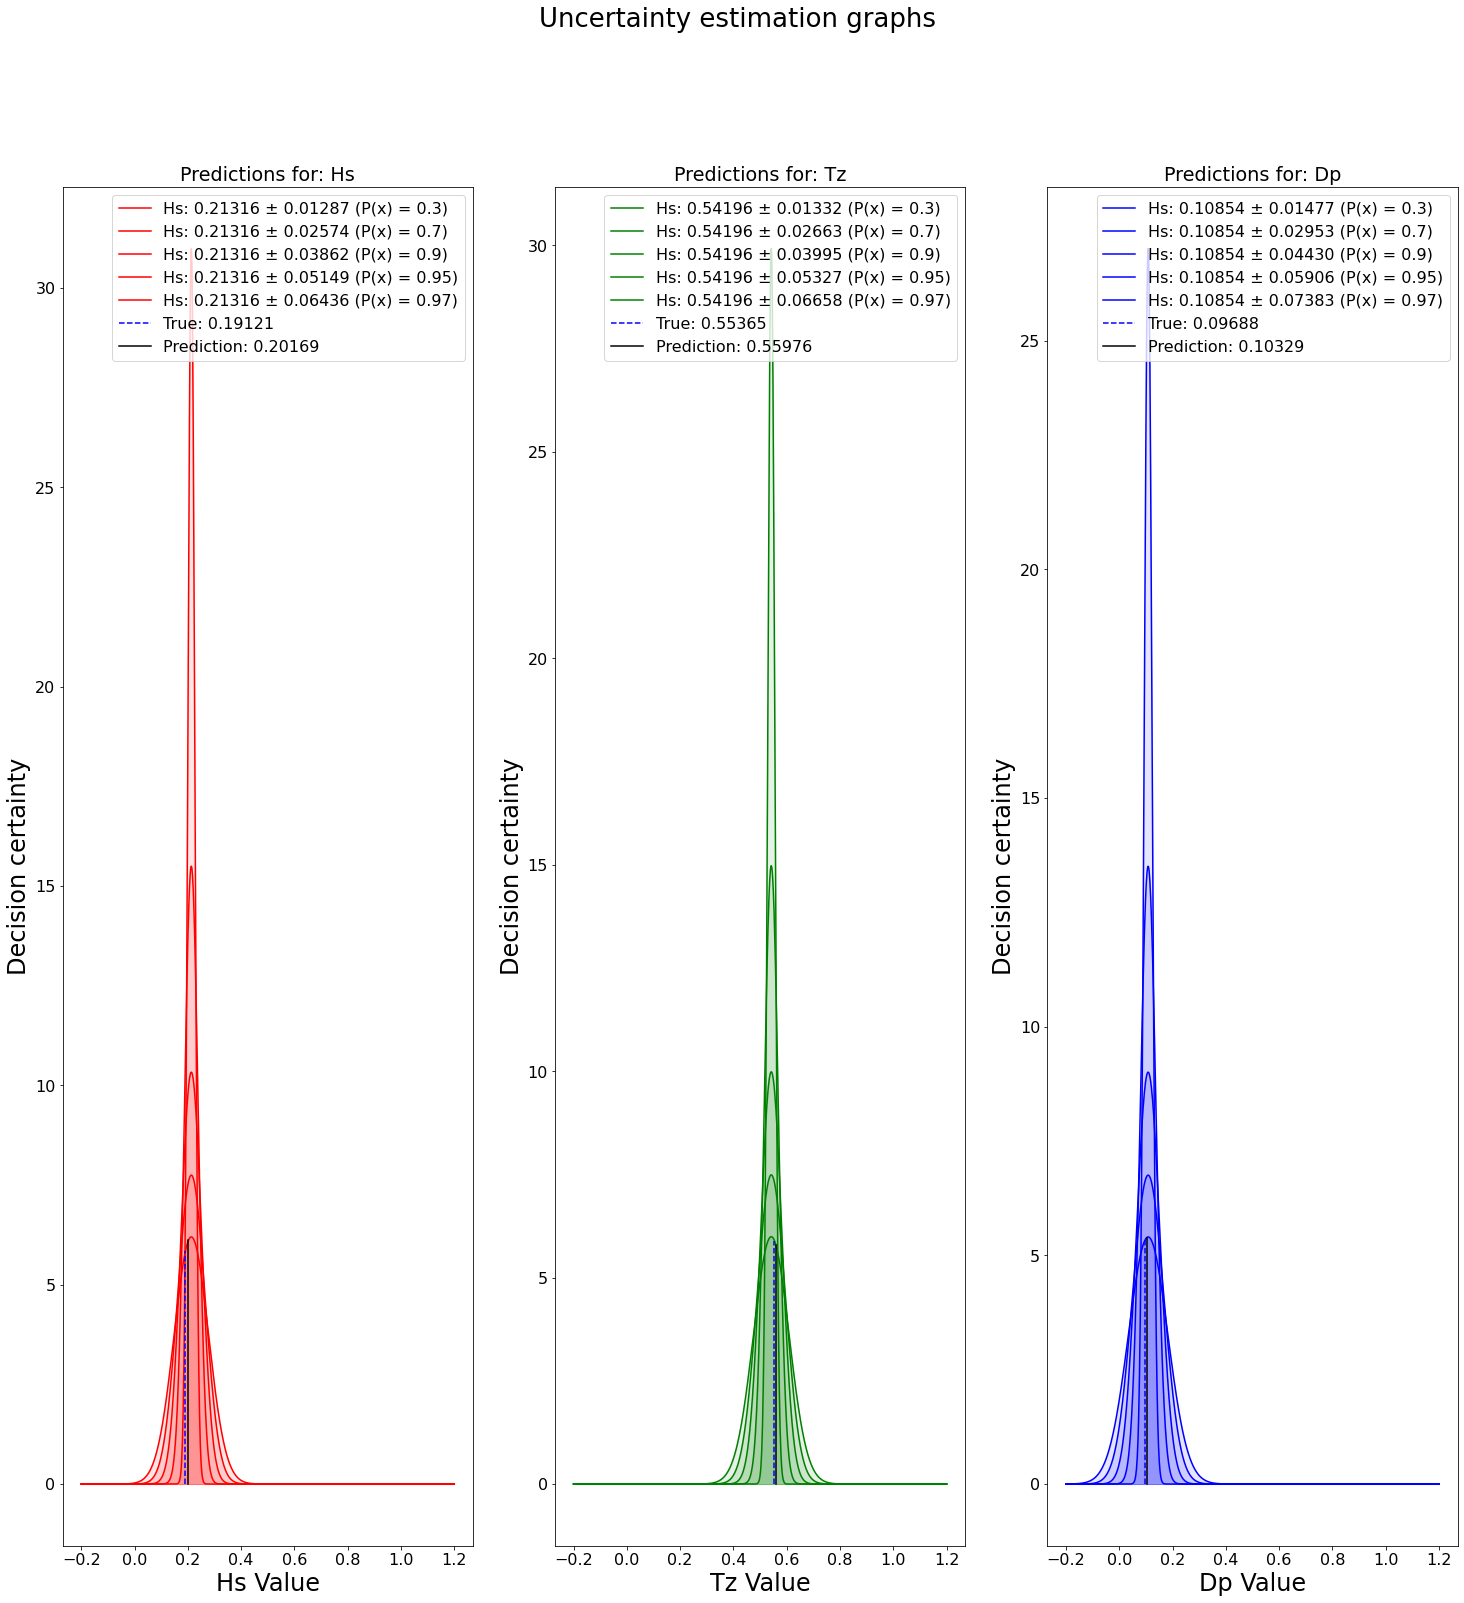

In [14]:
evaluation = evaluate_model(path)

data_params_valid = data_params("/home/franko/Desktop/DSelimovcProject/Dataset/", 'valid', True, 1 , 1)
data_params_test = data_params("/home/franko/Desktop/DSelimovcProject/Dataset/", 'test', True, 1 , 1)

dl_valid = init_dataloader(data_params_valid)
dl_test = init_dataloader(data_params_test)




for ind, item in enumerate(dl_valid):
    if ind != 200:
        continue
    _input, _output, _info = item
    _results_dict = {'Hs': [], 'Tz': [], 'Dp': []}
    for i in range(100):
        _constant = evaluation.evaluate(_input)
        _dinamic = evaluation.evaluate_dropout(_input)
        #print(_constant[0], ":", _dinamic[0])
        _data = _dinamic[0].to('cpu').detach().numpy()
        #print(_data[0][0])
        _results_dict['Hs'].append(_data[0][0])
        _results_dict['Tz'].append(_data[0][1])
        _results_dict['Dp'].append(_data[0][2])
    _constant = _constant[0].to('cpu').detach().numpy()[0]
    _output = _output[0].to('cpu').detach().numpy()
    break

plot_gaussians_unc(_results_dict, _constant, _output, "truc-blah.svg", scale_std = 5)

### Check if uncertainty helps

In [ ]:
evaluation = evaluate_model(path)

data_params_valid = data_params("/home/franko/Desktop/DSelimovcProject/Dataset/", 'valid', True, 1 , 1)
data_params_test = data_params("/home/franko/Desktop/DSelimovcProject/Dataset/", 'test', True, 1 , 1)

dl_valid = init_dataloader(data_params_valid)
dl_test = init_dataloader(data_params_test)



correct = 0
wrong = 0
for ind, item in enumerate(dl_valid):
    _results_dict = {'Hs': [], 'Tz': [], 'Dp': []}
    print(ind, end = '\r')
    _input, _output, _info = item
    _input = _input.repeat(100, 1, 1, 1)    
    #print(inp[0], inp[1])
    #print(inp.shape)
    _prediction, _ = evaluation.evaluate_dropout(_input)    
    
    _output = _output.to('cpu').detach().numpy()[0]
    _prediction = _prediction.to('cpu').detach().numpy()
    
    
    for i in range(100):
        _results_dict['Hs'].append(_prediction[i][0])
        _results_dict['Tz'].append(_prediction[i][1])
        _results_dict['Dp'].append(_prediction[i][2])
    
    # HS
    if (_output[0] < (np.mean(_results_dict['Hs']) +  3*np.std(_results_dict['Hs'])) and 
        _output[0] > (np.mean(_results_dict['Hs']) -  3*np.std(_results_dict['Hs'])) and 
        _output[1] < (np.mean(_results_dict['Tz']) +  3*np.std(_results_dict['Tz'])) and 
        _output[1] > (np.mean(_results_dict['Tz']) -  3*np.std(_results_dict['Tz'])) and 
        _output[2] < (np.mean(_results_dict['Dp']) +  3*np.std(_results_dict['Dp'])) and 
        _output[2] > (np.mean(_results_dict['Dp']) -  3*np.std(_results_dict['Dp']))):
            correct += 1

    else:
            wrong += 1

    

print(f"Correct: {correct}, Wrong: {wrong}, Total: {correct+wrong}")

In [ ]:
evaluation = evaluate_model(path)

data_params_valid = data_params("/home/franko/Desktop/DSelimovcProject/Dataset/", 'valid', True, 1 , 1)
data_params_test = data_params("/home/franko/Desktop/DSelimovcProject/Dataset/", 'test', True, 1 , 1)

dl_valid = init_dataloader(data_params_valid)
dl_test = init_dataloader(data_params_test)



correct = 0
wrong = 0
for ind, item in enumerate(dl_test):
    if ind == 150:
        break
    _results_dict = {'Hs': [], 'Tz': [], 'Dp': []}
    print(ind, end = '\r')
    _input, _output, _info = item
    _input = _input.repeat(100, 1, 1, 1)    
    #print(inp[0], inp[1])
    #print(inp.shape)
    _prediction, _ = evaluation.evaluate_dropout(_input)    
    
    _output = _output.to('cpu').detach().numpy()[0]
    _prediction = _prediction.to('cpu').detach().numpy()
    
    for i in range(100):
        _results_dict['Hs'].append(_prediction[i][0])
        _results_dict['Tz'].append(_prediction[i][1])
        _results_dict['Dp'].append(_prediction[i][2])
    
    # HS
    if (_output[0] < (np.mean(_results_dict['Hs']) +  4* np.std(_results_dict['Hs'])) and 
        _output[0] > (np.mean(_results_dict['Hs']) -  4* np.std(_results_dict['Hs'])) and 
        _output[1] < (np.mean(_results_dict['Tz']) +  4*np.std(_results_dict['Tz'])) and 
        _output[1] > (np.mean(_results_dict['Tz']) -  4*np.std(_results_dict['Tz'])) and 
        _output[2] < (np.mean(_results_dict['Dp']) +  4*np.std(_results_dict['Dp'])) and 
        _output[2] > (np.mean(_results_dict['Dp']) -  4*np.std(_results_dict['Dp']))):
            correct += 1
    else:
            wrong += 1
        
    

print(f"Correct: {correct}, Wrong: {wrong}, Total: {correct+wrong}")